Trades:  999 
Wins:  494 
Losses:  396 
Breakeven:  109 
Win / Loss Ratio:  1.247 
Mean Win:  0.445 
Mean Loss: -0.491 
Mean:  0.025 
Std Dev:  0.605 
Max Loss:  -4.175 
Max Win:  1.969 
Sharpe Ratio:  0.6662


array([], dtype=float64)

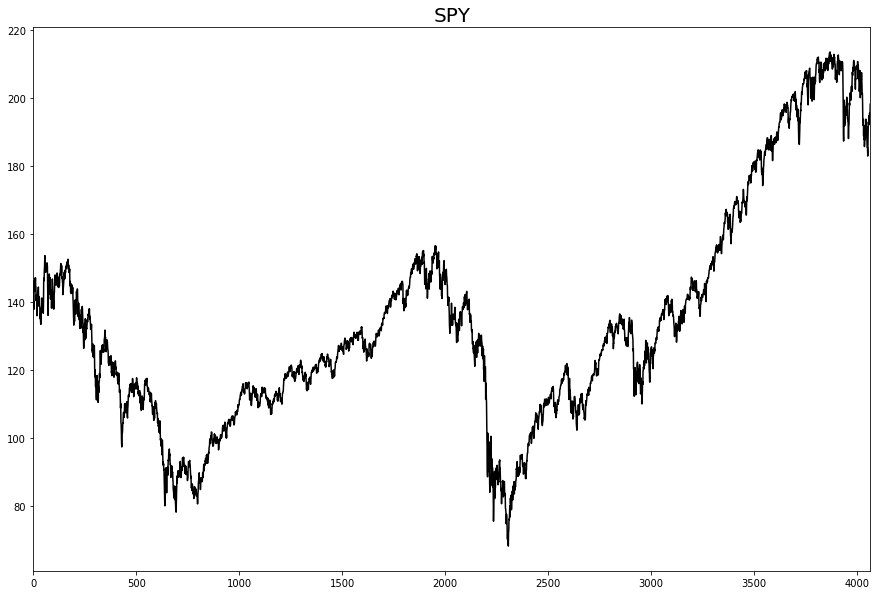

In [13]:
import pandas as pd
from pandas_datareader import data, wb
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
pd.set_option('display.max_colwidth', 200)

import pandas_datareader as pdr
start_date = pd.to_datetime('2000-01-01')
stop_date = pd.to_datetime('2016-03-01')

# close connection to finace.yahoo
#spy = pdr.data.get_data_yahoo('SPY', start_date, stop_date)
#spy.to_csv('spy.csv')
spy = pd.read_csv('spy.csv')
spy_c = spy['Close']

fig, ax = plt.subplots(figsize = (15, 10))
spy_c.plot(color = 'k')
plt.title("SPY", fontsize = 20)

first_open = spy['Open'].iloc[0]
last_close = spy['Close'].iloc[-1]

spy['Daily Change'] = pd.Series(spy['Close'] - spy['Open'])
np.std(spy['Daily Change'])
spy['Overnight Change'] = pd.Series(spy['Open'] - spy['Close'].shift(1))
np.std(spy['Overnight Change'])

spy[spy['Daily Change'] < 0]['Daily Change'].mean()
spy[spy['Overnight Change'] < 0]['Overnight Change'].mean()

daily_rtn = ((spy['Close'] - spy['Close'].shift(1))/ spy['Close'].shift(1)) * 100
id_rtn = ((spy['Close'] - spy['Open'])/ spy['Open']) * 100
on_rtn = ((spy['Open'] - spy['Close'].shift(1))/ spy['Close'].shift(1)) * 100

def get_stats(s, n = 252):
    s = s.dropna()
    wins = len(s[s > 0])
    losses = len(s[s < 0])
    evens = len(s[s == 0])
    mean_w = round(s[s > 0].mean(), 3)
    mean_l = round(s[s < 0].mean(), 3)
    win_r = round(wins / losses, 3)
    mean_trd = round(s.mean(), 3)
    sd = round(np.std(s), 3)
    max_l = round(s.min(), 3)
    max_w = round(s.max(), 3)
    sharpe_r = round((s.mean()/ np.std(s)) * np.sqrt(n), 4)
    cnt = len(s)
    print('Trades: ', cnt,\
         '\nWins: ', wins,\
         '\nLosses: ', losses,\
         '\nBreakeven: ', evens,\
         '\nWin / Loss Ratio: ', win_r,\
         '\nMean Win: ', mean_w,\
         '\nMean Loss:', mean_l,\
         '\nMean: ', mean_trd,\
         '\nStd Dev: ', sd,\
         '\nMax Loss: ', max_l,\
         '\nMax Win: ', max_w,\
         '\nSharpe Ratio: ', sharpe_r)
    
#get_stats(daily_rtn)
#get_stats(id_rtn)
#get_stats(on_rtn)

long_day_rtn = ((spy['Close'] - spy['Close'].shift(1))/ spy['Close'].shift(1))* 100
long_id_rtn = ((spy['Close'] - spy['Open']) / spy['Open']) * 100
long_on_rtn = ((spy['Open'] - spy['Close'].shift(1)) / spy['Close'].shift(1)) * 100

(spy['Close'] - spy['Close'].shift(1)).sum()
(spy['Close'] - spy['Open']).sum()
(spy['Open'] - spy['Close'].shift(1)).sum()

#get_stats(long_day_rtn)
#get_stats(long_id_rtn)
#get_stats(long_on_rtn)

# SVM Predict Stocks Close Price
for i in range(1, 21, 1):
    spy.loc[:, 'Close Minus ' + str(i)] = spy['Close'].shift(i)
spy20 = spy[[x for x in spy.columns if 'Close Minus' in x or x == 'Close']].iloc[20: ,]
spy20 = spy20.iloc[:, : : -1]

from sklearn.svm import SVR
clf = SVR(kernel = 'linear')
X_train = spy20[: -1000]
y_train = spy20['Close'].shift(-1)[: -1000]
X_test = spy20[-1000 :]
y_test = spy20['Close'].shift(-1)[-1000: ]

model = clf.fit(X_train, y_train)
preds = model.predict(X_test)

tf = pd.DataFrame(list(zip(y_test, preds)), columns = ['Next Day Close', 'Predicted Next Day Close'], index = y_test.index)

cdc = spy[['Close']].iloc[-1000 :]
ndo = spy[['Open']].iloc[-1000 :].shift(-1)
tf1 = pd.merge(tf, cdc, left_index = True, right_index = True)
tf2 = pd.merge(tf1, ndo, left_index = True, right_index = True)
tf2.columns = ['Next Day Close', 'Predicted Next Day Close', 'Current Day Close', 'Next Day Open']

def get_signal(r):
    if r['Predicted Next Day Close'] > r['Next Day Open'] + 1:
        return 0
    else:
        return 1

def get_ret(r):
    if r['Signal'] == 1:
        return ((r['Next Day Close'] - r['Next Day Open'])/ r['Next Day Open']) * 100
    else:
        return 0
    
tf2 = tf2.assign(Signal = tf2.apply(get_signal, axis = 1))
tf2 = tf2.assign(PnL = tf2.apply(get_ret, axis = 1))
(tf2[tf2['Signal'] == 1]['Next Day Close'] - tf2[tf2['Signal'] == 1]['Next Day Open']).sum() 
get_stats(tf2['PnL'])




In [ ]:
# dynamic time warping

import pandas as pd
from pandas_datareader import data, wb
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
pd.set_option('display.max_colwidth', 200)

import pandas_datareader as pdr
start_date = pd.to_datetime('2000-01-01')
stop_date = pd.to_datetime('2016-03-01')

# close connection to finace.yahoo
#spy = pdr.data.get_data_yahoo('SPY', start_date, stop_date)
#spy.to_csv('spy.csv')
spy = pd.read_csv('spy.csv')
spy_c = spy['Close']

spy['Daily Change'] = pd.Series(spy['Close'] - spy['Open'])
#np.std(spy['Daily Change'])
spy['Overnight Change'] = pd.Series(spy['Open'] - spy['Close'].shift(1))
#np.std(spy['Overnight Change'])

from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

def dtw_dist(x, y):
    distance, path = fastdtw(x, y, dist = euclidean)
    return distance

tseries = []
tlen = 5
for i in range(tlen, len(spy), tlen):
    pctc = spy['Close'].iloc[(i-tlen):i].pct_change()[1: ].values * 100
    #print(spy['Close'].iloc[(i-tlen):i].pct_change())
    res = spy['Close'].iloc[(i-tlen):(i + 1)].pct_change()[-1 :] * 100
    #print(res)
    tseries.append((pctc, res))
    
dist_pairs = []
for i in range(len(tseries)):
    for j in range(len(tseries)):
        dist = dtw_dist(tseries[i][0], tseries[j][0])
        #print(dist)
        dist_pairs.append((i, j, dist, tseries[i][1], tseries[j][1]))
        
dist_frame = pd.DataFrame(dist_pairs, columns = ['A', 'B', 'Dist', 'A Ret', 'B Ret'])
sf = dist_frame[dist_frame['Dist'] > 0].sort_values(['A', 'B']).reset_index(drop = 1)

sfe = sf[sf['A'] < sf['B']]
winf = sfe[(sfe['Dist'] <= 1) & (sfe['A Ret'] > 0)]

winf
